In [71]:
# 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [72]:
# 그래프 설정
# 한글폰트 설정
plt.rcParams['font.family'] = 'NanumBarunGothic'
sns.set(font='NanumBarunGothic')

# 그래프 설정
sns.set_style('white')

# 팔레트 설정
oryel = ['#E0B03C','#F1BA75','#F69960','#F97857','#F25958']
sns.set_palette(sns.color_palette(oryel))

In [73]:
df_case = pd.read_csv('customer_cases.csv', index_col=0)
df_cst = pd.read_csv('customer_info.csv', index_col=0)
df_prdt = pd.read_csv('customer_product.csv', index_col=0)
df_prdt_info = pd.read_csv('product_info.csv', index_col=0)
print('case data:', df_case.shape)
print('customer data:', df_cst.shape)
print('customer-product data:', df_prdt.shape)
print('product data:', df_prdt_info.shape)

case data: (330512, 5)
customer data: (508932, 3)
customer-product data: (508932, 4)
product data: (2, 3)


In [74]:
df_case[df_case['customer_id']=='C2477']

,case_id,date_time,customer_id,channel,reason
30,CC130,2017-01-02 11:45:47,C2477,phone,signup
111,CC211,2017-01-03 14:30:38,C2477,phone,support


customer_id가 중복인 경우는 구독신청 후 서비스 이용 관련하여 연락이 온 경우임

In [75]:
# 중복값들만 추출
cst_dup = df_case[df_case['customer_id'].duplicated()]
# customer_id가 중복된 경우는 모두 support
# 즉, 기존 이용객의 이용 관련 전화
(cst_dup['reason']=='signup').sum()

0

In [76]:
# customer_id 중복된 고객 이용행태
a = cst_dup.groupby('customer_id').count()
print('고객당 support 최대 이용건수', a['case_id'].max())
print('고객당 support 평균 이용건수', a['case_id'].mean())

고객당 support 최대 이용건수 4
고객당 support 평균 이용건수 1.119137734996807


In [77]:
# suppot 행 제거
df_sign = df_case.drop(cst_dup.index)
df_sign.shape

(258660, 5)

### 데이터셋 합치기

In [78]:
# 합칠 데이터셋에 중복값 있는지 확인
print(df_cst.duplicated().sum())
print(df_prdt.duplicated().sum())

0
0


In [79]:
# 데이터셋 합치기
df = pd.merge(df_sign, df_cst, how='left', on='customer_id')
df = pd.merge(df, df_prdt, how='left', on='customer_id')
print(df.shape)
df.head()

(258660, 10)


,case_id,date_time,customer_id,channel,reason,age,gender,product,signup_date_time,cancel_date_time
0,CC101,2017-01-01 10:32:03,C2448,phone,signup,76,female,prd_1,2017-01-01 10:35:09,NaN
1,CC102,2017-01-01 11:35:47,C2449,phone,signup,61,male,prd_1,2017-01-01 11:39:29,2021-09-05 10:00:02
2,CC103,2017-01-01 11:37:09,C2450,phone,signup,58,female,prd_1,2017-01-01 11:42:00,2019-01-13 16:24:55
3,CC104,2017-01-01 13:28:14,C2451,phone,signup,62,female,prd_2,2017-01-01 13:32:08,NaN
4,CC105,2017-01-01 13:52:22,C2452,phone,signup,71,male,prd_1,2017-01-01 13:57:30,2021-06-28 18:06:01


### EDA / Feature Engineering

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258660 entries, 0 to 258659
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   case_id           258660 non-null  object
 1   date_time         258660 non-null  object
 2   customer_id       258660 non-null  object
 3   channel           258660 non-null  object
 4   reason            258660 non-null  object
 5   age               258660 non-null  int64 
 6   gender            258660 non-null  object
 7   product           258660 non-null  object
 8   signup_date_time  258660 non-null  object
 9   cancel_date_time  59578 non-null   object
dtypes: int64(1), object(9)
memory usage: 21.7+ MB


In [81]:
df.isnull().sum()

case_id                  0
date_time                0
customer_id              0
channel                  0
reason                   0
age                      0
gender                   0
product                  0
signup_date_time         0
cancel_date_time    199082
dtype: int64

cancel_date_time 외에는 결측치 없음. 구독취소를 하지 않은 경우 cancel_date_time이 결측치로 나타남.
즉 cancel_date_time의 결측치는 현재 구독중인 이용자를 의미

컬럼 정리
1. case_id, customer_id   
   - 모델 학습 시 제거할 것, 수치만 남겨서 int 형변환 
2. date_time : case 일자이므로 제거
3. reason : signup case만 추출했으므로 제거
4. product : prd_1은 'annual', prd_2는 'monthly'로 변경
5. signup/cancel_date_time
   - date까지만 사용   
   - cancel_date_time : 결측치 0으로 채우기
   - cancel-signup해서 구독기간 특성 만들 것   
6. age : 연령대로 구분

In [82]:
# feature engineering

# customer_id int형변환
df['id'] = df['customer_id'].str.extract('(\d+)')
df['id'].astype(int)

# prouct명으로 변경
df['product'] = df['product'].replace({'prd_1':'annual', 'prd_2':'monthly'})

# age : min=22, max=78
# 20대~70대로 구분
def age_group(age):
    age = (age//10)*10 #10으로 나눈 몫*10
    return age

age_gr = df.age.apply(age_group)
age_gr = age_gr.astype('category')

df.insert(2, 'age_gr', age_gr)

# 불필요한 특성 제거
dels = ['case_id', 'date_time', 'reason', 'customer_id', 'age']
df.drop(columns=dels, inplace=True)

# 컬럼 순서 변경
df = df[['id','age_gr','gender','product','channel','signup_date_time', 'cancel_date_time']]

df.head()

,id,age_gr,gender,product,channel,signup_date_time,cancel_date_time
0,2448,70,female,annual,phone,2017-01-01 10:35:09,NaN
1,2449,60,male,annual,phone,2017-01-01 11:39:29,2021-09-05 10:00:02
2,2450,50,female,annual,phone,2017-01-01 11:42:00,2019-01-13 16:24:55
3,2451,60,female,monthly,phone,2017-01-01 13:32:08,NaN
4,2452,70,male,annual,phone,2017-01-01 13:57:30,2021-06-28 18:06:01


In [83]:
# 구독 취소 고객 여부
# 결측치를 0으로 채운 후 구독여부 구분
df['cancel_date_time']=df['cancel_date_time'].fillna(0)

lst = []
for i in df.index:
    if df.loc[i, 'cancel_date_time'] == 0:
        lst.append(0) # 취소 안한 사람(구독 유지)
    else:
        lst.append(1) # 취소한 사람(취소 = 1)
df['cancel'] = lst
df.head()

,id,age_gr,gender,product,channel,signup_date_time,cancel_date_time,cancel
0,2448,70,female,annual,phone,2017-01-01 10:35:09,0,0
1,2449,60,male,annual,phone,2017-01-01 11:39:29,2021-09-05 10:00:02,1
2,2450,50,female,annual,phone,2017-01-01 11:42:00,2019-01-13 16:24:55,1
3,2451,60,female,monthly,phone,2017-01-01 13:32:08,0,0
4,2452,70,male,annual,phone,2017-01-01 13:57:30,2021-06-28 18:06:01,1


In [84]:
# 구독기간 계산 위한 컬럼 생성
df['max_date'] = df['cancel_date_time']
df['max_date']=df['max_date'].replace(0,'2021-12-31')

# date와 time  분리
df['s_date'],df['s_time'] = df['signup_date_time'].str.split(' ',1).str
df['c_date'],df['c_time'] = df['max_date'].str.split(' ',1).str
df.drop(columns=['s_time','c_time'], axis=1, inplace=True)

# 날짜 계산 위해 datetime 형변환
df['s_date'] = pd.to_datetime(df['s_date'], format='%Y-%m-%d')
df['c_date'] = pd.to_datetime(df['c_date'], format='%Y-%m-%d')

# 구독기간 계산
df['period'] = df['c_date'] - df['s_date']
df['period_m'] = round(df['period'].dt.days / 30.4,1) # timedelta를 int로 변환(일 단위) 후 개월 수 환산
df.drop('period',axis=1, inplace=True)

# 연도 분리
df['s_year'] = df['s_date'].dt.year.astype(int)
df['c_year'] = df['c_date'].dt.year.astype(int)
df.head()

,id,age_gr,gender,product,channel,signup_date_time,cancel_date_time,cancel,max_date,s_date,c_date,period_m,s_year,c_year
0,2448,70,female,annual,phone,2017-01-01 10:35:09,0,0,2021-12-31,2017-01-01,2021-12-31,60.0,2017,2021
1,2449,60,male,annual,phone,2017-01-01 11:39:29,2021-09-05 10:00:02,1,2021-09-05 10:00:02,2017-01-01,2021-09-05,56.2,2017,2021
2,2450,50,female,annual,phone,2017-01-01 11:42:00,2019-01-13 16:24:55,1,2019-01-13 16:24:55,2017-01-01,2019-01-13,24.4,2017,2019
3,2451,60,female,monthly,phone,2017-01-01 13:32:08,0,0,2021-12-31,2017-01-01,2021-12-31,60.0,2017,2021
4,2452,70,male,annual,phone,2017-01-01 13:57:30,2021-06-28 18:06:01,1,2021-06-28 18:06:01,2017-01-01,2021-06-28,53.9,2017,2021


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258660 entries, 0 to 258659
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                258660 non-null  object        
 1   age_gr            258660 non-null  category      
 2   gender            258660 non-null  object        
 3   product           258660 non-null  object        
 4   channel           258660 non-null  object        
 5   signup_date_time  258660 non-null  object        
 6   cancel_date_time  258660 non-null  object        
 7   cancel            258660 non-null  int64         
 8   max_date          258660 non-null  object        
 9   s_date            258660 non-null  datetime64[ns]
 10  c_date            258660 non-null  datetime64[ns]
 11  period_m          258660 non-null  float64       
 12  s_year            258660 non-null  int32         
 13  c_year            258660 non-null  int32         
dtypes: c

In [86]:
df.shape

(258660, 14)

연도별, 구독형태별 이용자 수

In [87]:
pl_signup = df.groupby(['s_year','product'], as_index=False)['id'].count()
pl_signup.columns = ['year','product','signup']
pl_signup

,year,product,signup
0,2017,annual,14487
1,2017,monthly,3552
2,2018,annual,23371
3,2018,monthly,7492
4,2019,annual,39365
5,2019,monthly,15231
6,2020,annual,37085
7,2020,monthly,29555
8,2021,annual,25039
9,2021,monthly,63483


In [88]:
# 구독취소한 사람 데이터
df_ccl = df[df['cancel']==1]
print(df_ccl.shape)
df_ccl.head()

(59578, 14)


,id,age_gr,gender,product,channel,signup_date_time,cancel_date_time,cancel,max_date,s_date,c_date,period_m,s_year,c_year
1,2449,60,male,annual,phone,2017-01-01 11:39:29,2021-09-05 10:00:02,1,2021-09-05 10:00:02,2017-01-01,2021-09-05,56.2,2017,2021
2,2450,50,female,annual,phone,2017-01-01 11:42:00,2019-01-13 16:24:55,1,2019-01-13 16:24:55,2017-01-01,2019-01-13,24.4,2017,2019
4,2452,70,male,annual,phone,2017-01-01 13:57:30,2021-06-28 18:06:01,1,2021-06-28 18:06:01,2017-01-01,2021-06-28,53.9,2017,2021
6,2454,50,male,annual,phone,2017-01-01 15:35:03,2021-06-01 17:09:40,1,2021-06-01 17:09:40,2017-01-01,2021-06-01,53.0,2017,2021
8,2456,70,female,annual,phone,2017-01-02 09:21:04,2017-06-08 15:57:45,1,2017-06-08 15:57:45,2017-01-02,2017-06-08,5.2,2017,2017


In [89]:
pl_cancel = df_ccl.groupby(['c_year','product'], as_index=False)['id'].count()
pl_cancel.columns = ['year','product','cancel']

# 연도별, 상품별 이용자수 취합
pl = pd.merge(pl_signup, pl_cancel) 
pl


,year,product,signup,cancel
0,2017,annual,14487,797
1,2017,monthly,3552,261
2,2018,annual,23371,2607
3,2018,monthly,7492,1032
4,2019,annual,39365,5519
5,2019,monthly,15231,2823
6,2020,annual,37085,9909
7,2020,monthly,29555,6572
8,2021,annual,25039,13690
9,2021,monthly,63483,16368


In [90]:
# 평균 구독 개월 수 추가(구독신청한 일자로부터의 구독개월 수)
pl_period = df.groupby(['s_year','product'], as_index=False)['period_m'].mean().round(2)
pl_period.columns = ['year','product','period']

pl=pd.merge(pl, pl_period) 
pl

,year,product,signup,cancel,period
0,2017,annual,14487,797,44.07
1,2017,monthly,3552,261,40.22
2,2018,annual,23371,2607,35.94
3,2018,monthly,7492,1032,32.66
4,2019,annual,39365,5519,26.70
5,2019,monthly,15231,2823,24.40
6,2020,annual,37085,9909,17.10
7,2020,monthly,29555,6572,16.29
8,2021,annual,25039,13690,7.06
9,2021,monthly,63483,16368,7.05


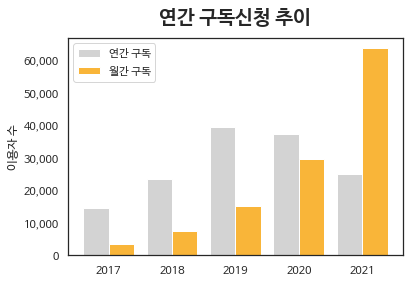

In [91]:
labels = ['2017','2018','2019','2020','2021']
value_a = pl[pl['product']=='annual']['signup']
value_b = pl[pl['product']=='monthly']['signup']

# 묶은 막대 그래프
def create_x(t, w, n, d):
    return [t*x + w*n for x in range(d)]
# n : This is our first dataset (out of 2)
# t : Number of dataset
# d : Number of sets of bars
# w : Width of each bar
value_a_x = create_x(2, 0.8, 1, 5)
value_b_x = create_x(2, 0.8, 2, 5)

plt.rcParams['font.family'] = 'NanumBarunGothic'
ax = plt.subplot()
ax.bar(value_a_x, value_a, color='lightgrey', label='연간 구독')
ax.bar(value_b_x, value_b, color='#F9B539', label='월간 구독')
middle_x = [(a+b)/2 for (a,b) in zip(value_a_x, value_b_x)]
ax.set_xticks(middle_x)
ax.set_xticklabels(labels)

plt.title('연간 구독신청 추이', size=20, weight='bold', pad=15)
plt.ylabel('이용자 수')
plt.legend()
# y축 천단위 , 표시
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);
plt.show()

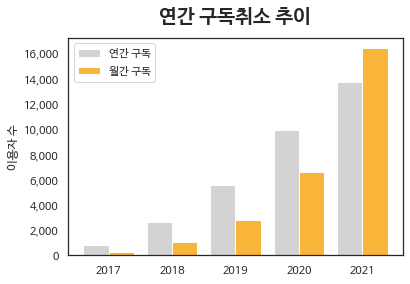

In [92]:
labels = ['2017','2018','2019','2020','2021']
value_a = pl[pl['product']=='annual']['cancel']
value_b = pl[pl['product']=='monthly']['cancel']

# 묶은 막대 그래프
def create_x(t, w, n, d):
    return [t*x + w*n for x in range(d)]
# n : This is our first dataset (out of 2)
# t : Number of dataset
# d : Number of sets of bars
# w : Width of each bar
value_a_x = create_x(2, 0.8, 1, 5)
value_b_x = create_x(2, 0.8, 2, 5)

plt.rcParams['font.family'] = 'NanumBarunGothic'
ax = plt.subplot()
ax.bar(value_a_x, value_a, color='lightgrey', label='연간 구독')
ax.bar(value_b_x, value_b, color='#F9B539', label='월간 구독')
middle_x = [(a+b)/2 for (a,b) in zip(value_a_x, value_b_x)]
ax.set_xticks(middle_x)
ax.set_xticklabels(labels)

plt.title('연간 구독취소 추이', size=20, weight='bold', pad=15)
plt.ylabel('이용자 수')
plt.legend()
# y축 천단위 , 표시
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);
plt.show()

- 2020년부터 월간 구독신청이 급증, 연간 구독의 취소가 더 많음  
- 그러나 이용자 수만으로 판단하기 애매. 유형별 취소율 살펴보자
- 연간 구독은 월간 구독보다 가격이 80% 저렴. 매출비중으로 볼 때 자사에 더 중요한 구독형태는 무엇?

In [93]:
# 연간 구독 이용자

from cgi import print_exception


pl_ann = pl[pl['product']=='annual'].reset_index(drop=True)

# 연도별 잔존 이용자
pl_ann['actual'] = pl_ann.signup - pl_ann.cancel
# 연도별 누적 이용객 수(이탈률 구할 때 사용)
lst = [13690]
for i in range(1,5):
    val = lst[i-1] + pl_ann.loc[i,'signup'] - pl_ann.loc[i,'cancel']
    lst.append(val)
pl_ann['cumul'] =lst

# 고객이탈률
# 당월 고객 이탈수 / 월초 고객 수 (당월 신규는 제외)
pl_ann['churn_rate'] = round(pl_ann['cancel'] / pl_ann['actual'],3)
pl_ann.head()


,year,product,signup,cancel,period,actual,cumul,churn_rate
0,2017,annual,14487,797,44.07,13690,13690,0.058
1,2018,annual,23371,2607,35.94,20764,34454,0.126
2,2019,annual,39365,5519,26.70,33846,68300,0.163
3,2020,annual,37085,9909,17.10,27176,95476,0.365
4,2021,annual,25039,13690,7.06,11349,106825,1.206


In [94]:
# 월간 구독 이용자
pl_mon = pl[pl['product']=='monthly'].reset_index(drop=True)

# 연도발 잔존 이용자
pl_mon['actual'] = pl_mon.signup - pl_mon.cancel
# 연도별 누적이용객 수
lst = [3291]
for i in range(1,5):
    val = lst[i-1] + pl_mon.loc[i,'signup'] - pl_mon.loc[i,'cancel']
    lst.append(val)
pl_mon['cumul'] =lst

# 고객이탈률
# 당월 고객 이탈수 / 월초 고객 수 (당월 신규는 제외)
pl_mon['churn_rate'] = round(pl_mon['cancel'] / pl_mon['actual'],3)
pl_mon.head()

,year,product,signup,cancel,period,actual,cumul,churn_rate
0,2017,monthly,3552,261,40.22,3291,3291,0.079
1,2018,monthly,7492,1032,32.66,6460,9751,0.160
2,2019,monthly,15231,2823,24.40,12408,22159,0.228
3,2020,monthly,29555,6572,16.29,22983,45142,0.286
4,2021,monthly,63483,16368,7.05,47115,92257,0.347


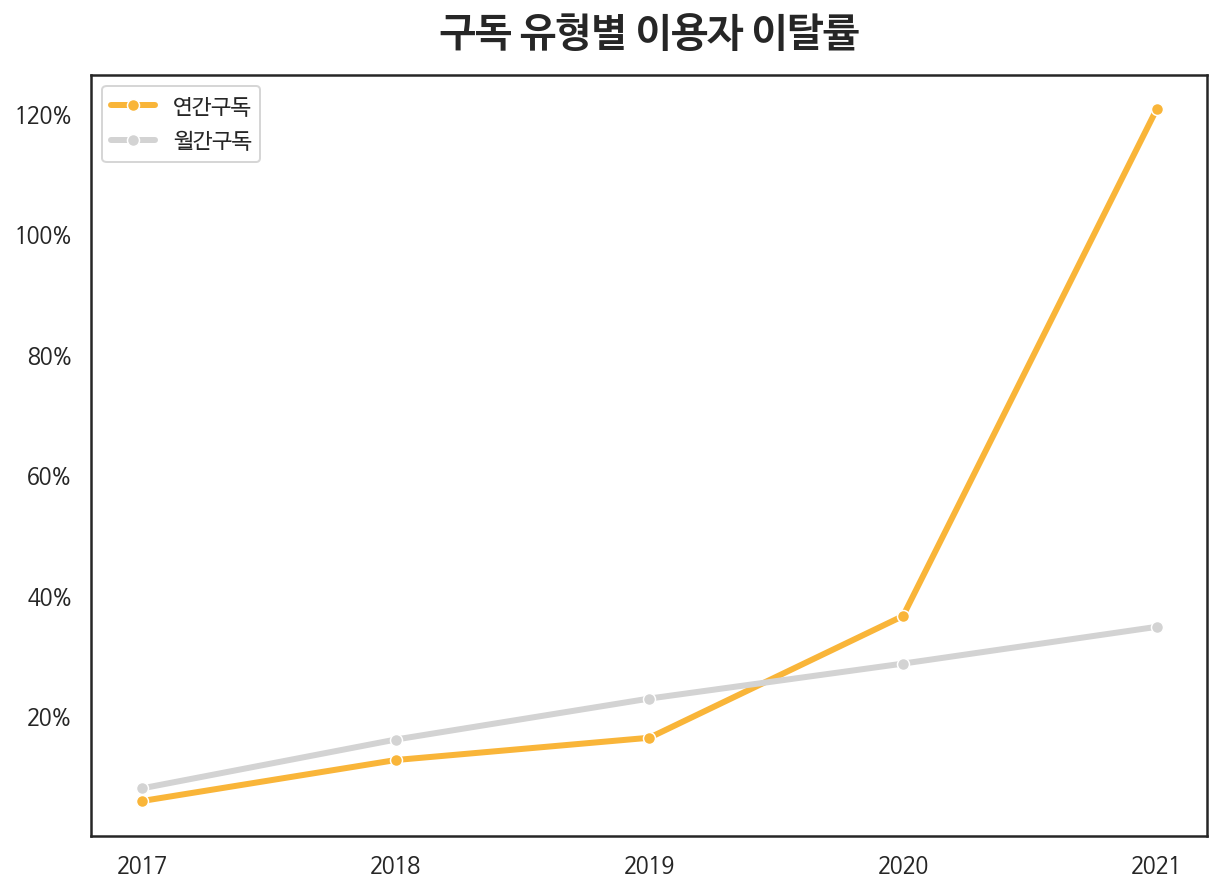

In [242]:
churn_rate = pd.DataFrame({'year' : [2017,2018,2019,2020,2021],
                        'annual':pl_ann['churn_rate'],
                        'monthly':pl_mon['churn_rate']})

plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.figure(figsize=(10,7))
sns.lineplot(x='year', y='annual', marker='o',data=churn_rate, color='#F9B539', linewidth='3')
sns.lineplot(x='year', y='monthly', marker='o',data=churn_rate, color='lightgrey', linewidth='3')
plt.title('구독 유형별 이용자 이탈률', size=20, weight='bold', pad=15)
plt.xticks(churn_rate['year'])
plt.legend(['연간구독', '월간구독'])
plt.xlabel('')
plt.ylabel('')
# 축 라벨 백분율로 표기
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0%}'.format(x) for x in current_values])
 
plt.show()

연간구독보다 월간구볻의 이탈률이 큼

In [96]:
ann_sales = (pl_ann.loc[4,'cumul'] * pl_ann['period'].mean() * 120).round(0).astype(int)
mon_sales = (pl_mon.loc[4,'cumul'] * pl_mon['period'].mean() * 125).round(0).astype(int)


sales = pd.DataFrame({'product':['annual','monthly'],'sales':[ann_sales, mon_sales]})
sales

,product,sales
0,annual,335524506
1,monthly,278200984


In [97]:
# product 시각화
fig = px.pie(values=sales['sales'],
             names=['연간구독','월간구독'],
             color_discrete_sequence=px.colors.sequential.Oryel)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(showlegend=False)
fig.show()

월간구독이 연간구독보다 판매가는 높지만 고객의 이탈률이 높음  
연간구독은 월간구독보다 평균 구독기간이 길어 비교적 장기적인 고객관계 형성 용이  
현재 구독 이용자 매출 비중에서도 연간구독이 더 큼  
따라서, 연간구독 이용자의 해지방어에 집중한다!

* * *

### 연간구독 해지 이용자 분석   
연간구독 해지 이용자의 특징을 분석하여 해지가 예상되는 고객을 분류하는 기준으로 설정하고자 함

In [98]:
ccl_ann = df_ccl[df_ccl['product']=='annual']
ccl_ann.drop(columns=['product','cancel'], inplace=True)
print(ccl_ann.shape)
ccl_ann.head()

(32522, 12)


,id,age_gr,gender,channel,signup_date_time,cancel_date_time,max_date,s_date,c_date,period_m,s_year,c_year
1,2449,60,male,phone,2017-01-01 11:39:29,2021-09-05 10:00:02,2021-09-05 10:00:02,2017-01-01,2021-09-05,56.2,2017,2021
2,2450,50,female,phone,2017-01-01 11:42:00,2019-01-13 16:24:55,2019-01-13 16:24:55,2017-01-01,2019-01-13,24.4,2017,2019
4,2452,70,male,phone,2017-01-01 13:57:30,2021-06-28 18:06:01,2021-06-28 18:06:01,2017-01-01,2021-06-28,53.9,2017,2021
6,2454,50,male,phone,2017-01-01 15:35:03,2021-06-01 17:09:40,2021-06-01 17:09:40,2017-01-01,2021-06-01,53.0,2017,2021
8,2456,70,female,phone,2017-01-02 09:21:04,2017-06-08 15:57:45,2017-06-08 15:57:45,2017-01-02,2017-06-08,5.2,2017,2017


In [99]:
ccl_ann.describe()

,period_m,s_year,c_year
count,32522.000000,32522.000000,32522.000000
mean,17.546402,2018.710411,2020.017404
std,12.962896,1.148577,1.063758
min,0.000000,2017.000000,2017.000000
25%,6.900000,2018.000000,2019.000000
50%,14.900000,2019.000000,2020.000000
75%,25.800000,2020.000000,2021.000000
max,59.900000,2021.000000,2021.000000


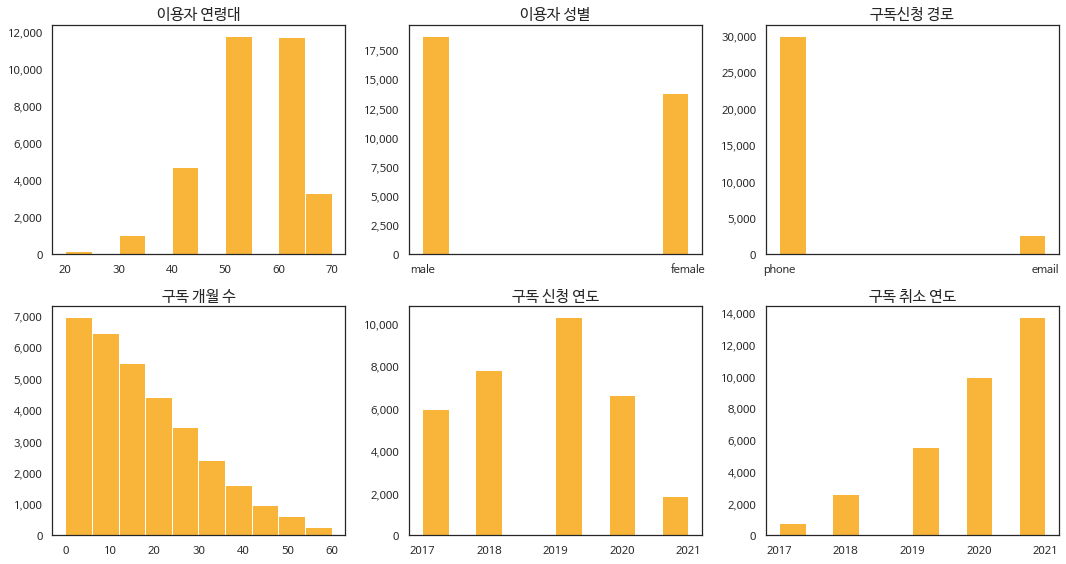

In [100]:
plt.rcParams['font.family'] = 'NanumBarunGothic'
cols = ['age_gr','gender','channel','period_m', 's_year', 'c_year']
title = ['이용자 연령대', '이용자 성별', '구독신청 경로', '구독 개월 수', '구독 신청 연도', '구독 취소 연도']

plt.figure(figsize=(15,8))


for i in range(0,6):
    plt.subplot(2,3,i+1)
    plt.title(title[i], fontsize=15)
    plt.hist(x=ccl_ann.loc[:,cols[i]], color='#F9B539')
    # y축 천단위 , 표시
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

plt.tight_layout()

<AxesSubplot:xlabel='period_m'>

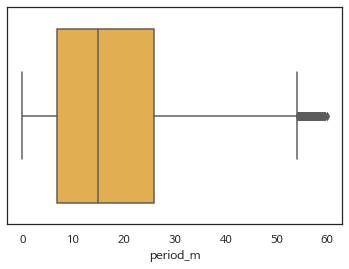

In [101]:
sns.boxplot(data=ccl_ann, x='period_m', color='#F9B539')

클러스터링

In [102]:
ccl_ann.head()

,id,age_gr,gender,channel,signup_date_time,cancel_date_time,max_date,s_date,c_date,period_m,s_year,c_year
1,2449,60,male,phone,2017-01-01 11:39:29,2021-09-05 10:00:02,2021-09-05 10:00:02,2017-01-01,2021-09-05,56.2,2017,2021
2,2450,50,female,phone,2017-01-01 11:42:00,2019-01-13 16:24:55,2019-01-13 16:24:55,2017-01-01,2019-01-13,24.4,2017,2019
4,2452,70,male,phone,2017-01-01 13:57:30,2021-06-28 18:06:01,2021-06-28 18:06:01,2017-01-01,2021-06-28,53.9,2017,2021
6,2454,50,male,phone,2017-01-01 15:35:03,2021-06-01 17:09:40,2021-06-01 17:09:40,2017-01-01,2021-06-01,53.0,2017,2021
8,2456,70,female,phone,2017-01-02 09:21:04,2017-06-08 15:57:45,2017-06-08 15:57:45,2017-01-02,2017-06-08,5.2,2017,2017


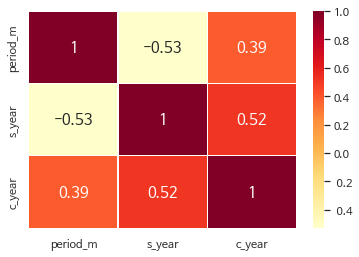

In [103]:
plt.rcParams['font.family'] = 'NanumBarunGothic'
sns.heatmap(ccl_ann.corr(), annot=True, annot_kws={'size':15}, cmap='YlOrRd', linewidth=0.3)
plt.show()

수치형만 상관관계 분석 → 무의미

In [104]:
# 구독기간에 따라 3개 유형으로 구분
short = ccl_ann.query('period_m<12') # 1년 이내에 구독 해지
#middle = ccl_ann.query('(period_m>=12) and (period_m<24)') 
long = ccl_ann.query('period_m>=12') # 재구독

lst_count = [short.shape[0], long.shape[0]] # middle.shape[0],
lst_count

[13390, 19132]

In [105]:
long.describe()

,period_m,s_year,c_year
count,19132.000000,19132.000000,19132.000000
mean,25.778120,2018.341888,2020.306032
std,10.625456,0.981633,0.858232
min,12.000000,2017.000000,2018.000000
25%,17.100000,2018.000000,2020.000000
50%,23.500000,2018.000000,2021.000000
75%,32.200000,2019.000000,2021.000000
max,59.900000,2020.000000,2021.000000


재정 자문 관련 콘텐츠 제공하므로 실용재에 가까움
연간 구독한 후 1년 이내에 구독취소를 했다면 정보에 만족도가 떨어졌거나 유익하지 않다고 느꼈을 가능성이 큼. 해지 막기 위해 노력해도 효과 없을 듯

연령대와 채널은 이용자 유형 간 큰 차이 없음. 전체 데이터의 채널 구성비와 유사

In [106]:
# 구독기간 1년 단위로
new = ccl_ann.query('period_m<12') # 1년 이내에 구독 해지
re1 = ccl_ann.query('(period_m>=12) and (period_m<24)')
re2 = ccl_ann.query('(period_m>=24) and (period_m<36)')
re3 = ccl_ann.query('(period_m>=36) and (period_m<48)')
re4 = ccl_ann.query('(period_m>=48) and (period_m<60)')

re_sub = pd.DataFrame({'category':['new','re1','re2','re3','re4'],
    'avg_period':[new['period_m'].mean().round(2),
                re1['period_m'].mean().round(2),
                re2['period_m'].mean().round(2),
                re3['period_m'].mean().round(2),
                re4['period_m'].mean().round(2)]})
re_sub['cancel_after'] = (re_sub['avg_period']%12).round(2)
re_sub

,category,avg_period,cancel_after
0,new,5.78,5.78
1,re1,17.50,5.50
2,re2,29.23,5.23
3,re3,41.05,5.05
4,re4,52.34,4.34


In [243]:
len(new), len(re1), len(re2), len(re3), len(re4)

(13390, 9882, 5845, 2550, 855)

In [107]:
print(re_sub['cancel_after'].mean().round(2))

5.18


재구독 후 4~5개월째에 구독 취소 → 1~2개월 전에 해지방어 하자!

* * *

### 모델링 위한 전처리
- 연간 구독자 대상

In [108]:
dfm = df[df['product']=='annual']
print(dfm.shape)
dfm.head()

(139347, 14)


,id,age_gr,gender,product,channel,signup_date_time,cancel_date_time,cancel,max_date,s_date,c_date,period_m,s_year,c_year
0,2448,70,female,annual,phone,2017-01-01 10:35:09,0,0,2021-12-31,2017-01-01,2021-12-31,60.0,2017,2021
1,2449,60,male,annual,phone,2017-01-01 11:39:29,2021-09-05 10:00:02,1,2021-09-05 10:00:02,2017-01-01,2021-09-05,56.2,2017,2021
2,2450,50,female,annual,phone,2017-01-01 11:42:00,2019-01-13 16:24:55,1,2019-01-13 16:24:55,2017-01-01,2019-01-13,24.4,2017,2019
4,2452,70,male,annual,phone,2017-01-01 13:57:30,2021-06-28 18:06:01,1,2021-06-28 18:06:01,2017-01-01,2021-06-28,53.9,2017,2021
5,2453,50,male,annual,phone,2017-01-01 15:26:14,0,0,2021-12-31,2017-01-01,2021-12-31,60.0,2017,2021


In [109]:
# 불필요한 특성 제거
dfm=dfm[['age_gr','gender','channel','period_m']]

# 컬럼명 정리
dfm.columns = ['age','gender','channel','period']
# 타겟값 추가
lst = []
for i in dfm.period:
    if (i%12 >=3.18) and (i%12 <=4.18):
        lst.append(1)
    else:
        lst.append(0)
dfm['churn'] = lst
dfm.head()

,age,gender,channel,period,churn
0,70,female,phone,60.0,0
1,60,male,phone,56.2,0
2,50,female,phone,24.4,0
4,70,male,phone,53.9,0
5,50,male,phone,60.0,0


결측치 없음

In [111]:
# 훈련/검증/테스트 데이터 구분
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    dfm, train_size=0.80, test_size=0.20, stratify=dfm['churn'], random_state=42)

train, val = train_test_split(
    train, train_size=0.80, test_size=0.20, random_state=42)

train.shape, val.shape, test.shape

((89181, 5), (22296, 5), (27870, 5))

In [112]:
target = 'churn'
features = dfm.drop(columns=[target]).columns

def divide_data(df):
    target = 'churn'
    features = dfm.drop(columns=[target]).columns
    X = df[features]
    y = df[target]
    return X, y

X_train, y_train = divide_data(train)
X_val, y_val = divide_data(val)
X_test, y_test = divide_data(test)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)


(89181, 4) (89181,) (22296, 4) (22296,) (27870, 4) (27870,)


In [195]:
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix # 오차행렬 히트맵
from sklearn.metrics import confusion_matrix # 오차행렬 생성
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats.distributions import uniform

0. 기준모델

In [114]:
# 기준모델 - 최빈값
y_base = [y_train.mode()]*len(y_train)

# 기준모델 정확도
print("training accuracy: ", accuracy_score(y_train, y_base).round(2))

training accuracy:  0.92


타겟 비율이 매우 불균형하기 때문에 정확도만 보고 성능 평가하기 어려움. 다른 지표도 함께보되 reall 잘 살펴보자. 해지고객 아니라고 판단했는데 맞을 경우가 치명적임

In [244]:
dfm['churn'].value_counts(normalize=True)

0    0.924914
1    0.075086
Name: churn, dtype: float64

1. 로지스틱회귀

In [115]:
X_train.head()

,age,gender,channel,period
137167,60,male,phone,6.3
64888,50,female,phone,30.9
162624,60,female,phone,11.4
154156,40,male,phone,19.6
17668,70,female,phone,51.0


In [116]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89181 entries, 137167 to 116676
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   age      89181 non-null  category
 1   gender   89181 non-null  object  
 2   channel  89181 non-null  object  
 3   period   89181 non-null  float64 
dtypes: category(1), float64(1), object(2)
memory usage: 2.8+ MB


In [138]:
# 수치형 데이터 1개뿐(period)이라 scaling 안함

ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(X_train)
X_val_ohe = ohe.transform(X_val)
X_test_ohe = ohe.transform(X_test)

logistic = LogisticRegression(class_weight='balanced')
logistic.fit(X_train_ohe, y_train)
y_val_pred_log = logistic.predict(X_val_ohe)
print('로지스틱회귀 훈련 정확도: ', logistic.score(X_train_ohe, y_train).round(2))
print('로지스틱회귀 검증 정확도: ', accuracy_score(y_val, y_val_pred_log).round(2))
print(classification_report(y_val, y_val_pred_log))


로지스틱회귀 훈련 정확도:  0.49
로지스틱회귀 검증 정확도:  0.5
              precision    recall  f1-score   support

           0       0.94      0.49      0.64     20652
           1       0.08      0.57      0.14      1644

    accuracy                           0.50     22296
   macro avg       0.51      0.53      0.39     22296
weighted avg       0.87      0.50      0.61     22296



In [239]:
df_prdt_info

,name,price,billing_cycle
product_id,,,
prd_1,annual_subscription,1200,12
prd_2,monthly_subscription,125,1


In [135]:
# 회귀계수가 양수인 특성 상위 3개
# print(pd.Series(logistic.coef_[0], logistic.feature_names_in_).sort_values(ascending=False).head(3))

2. random forest

random forest 훈련 정확도:  0.9764187439028492
random forest 검증 정확도:  0.9773950484391819
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     20652
           1       1.00      0.69      0.82      1644

    accuracy                           0.98     22296
   macro avg       0.99      0.85      0.90     22296
weighted avg       0.98      0.98      0.98     22296



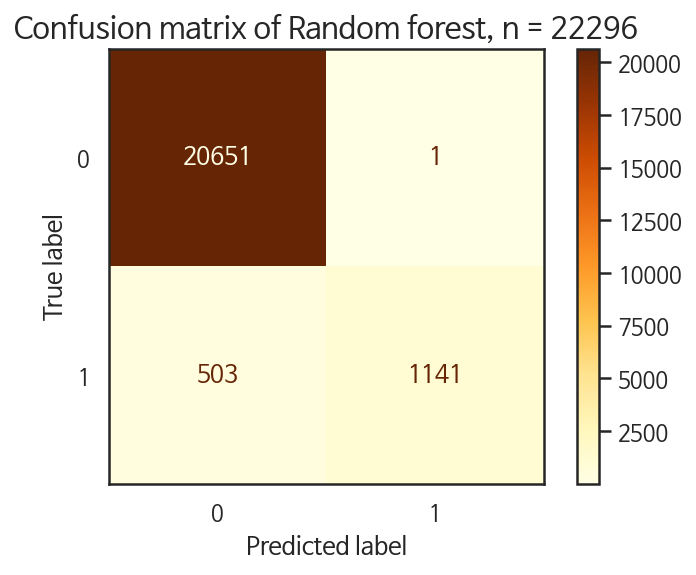

In [247]:
pipe_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(
        random_state=42, 
        oob_score=True, 
        n_jobs=-1, 
        class_weight='balanced',
        max_depth=5
        )
    )
pipe_rf.fit(X_train, y_train)
y_val_pred_rf = pipe_rf.predict(X_val)
print("random forest 훈련 정확도: ", pipe_rf.score(X_train, y_train))
print("random forest 검증 정확도: ", pipe_rf.score(X_val, y_val))
print(classification_report(y_val, y_val_pred_rf))

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe_rf, X_val, y_val,
                            cmap=plt.cm.YlOrBr,
                            ax=ax)
plt.title(f'Confusion matrix of Random forest, n = {len(y_val)}', fontsize=15)
plt.show()

3. XBGoost

xgboost 훈련 정확도 0.8397528621567374
xgboost 검증 정확도 0.8404646573376391
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     20652
           1       0.32      1.00      0.48      1644

    accuracy                           0.84     22296
   macro avg       0.66      0.91      0.69     22296
weighted avg       0.95      0.84      0.87     22296



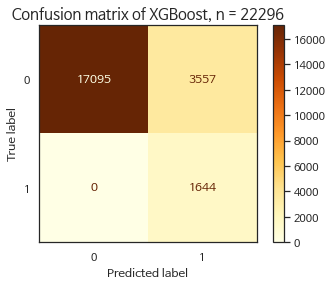

In [192]:
pipe_xgb = make_pipeline(
        OrdinalEncoder(),
        XGBClassifier(
                booster='gbtree', # dart보다 성능 좋았음
                objective='binary:logistic',
                eval_metric="error",  # error = 1 - accuracy 지표를 사용해 평가합니다.
                random_state=42,
                n_jobs=-1,
                max_depth=2,
                learning_rate=0.05,
                scale_pos_weight = (y_val == 0).sum() / (y_val == 1).sum(),
                colsample_bytree=0.2, # 컬럼 중 일부 샘플링해서 학습, 작을수록 과적합 감소
                subsample=0.2, # 데이터 중 일부 샘플링해서 학습, 낮을수록 과적합 감소
                min_child_weight=32,# 관측치에 대한 가중치 합의 최소
                reg_lambda=3, # 클수록 과적합 감소
                gamma=2
                )
        )

# early stopping 설정
# watchlist = [(X_train, y_train), (X_val, y_val)]
# pipe_xgb.fit(X_train, y_train, eval_set=watchlist, early_stopping_rounds=50)

pipe_xgb.fit(X_train, y_train)
y_val_pred_xgb = pipe_xgb.predict(X_val)

print("xgboost 훈련 정확도", pipe_xgb.score(X_train, y_train))
print("xgboost 검증 정확도", pipe_xgb.score(X_val, y_val))
print(classification_report(y_val, y_val_pred_xgb))

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe_xgb, X_val, y_val,
                            cmap=plt.cm.YlOrBr,
                            ax=ax)
plt.title(f'Confusion matrix of XGBoost, n = {len(y_val)}', fontsize=15)
plt.show()

과적합이 적은 random forest 모델 선정

* * *
### 성능개선
하이퍼파라미터 튜닝


In [ ]:
# 기존 모델
pipe_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(
        random_state=42, 
        oob_score=True, 
        n_jobs=-1, 
        class_weight='balanced',
        )
    )

In [202]:
# randomized search CV
pipe_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(
        random_state=42, 
        oob_score=True, 
        n_jobs=2, 
        class_weight='balanced',
        )
    )

params = {
    'randomforestclassifier__criterion' : ['gini', 'entropy'],
    'randomforestclassifier__max_depth': [3,4,5,6,7],
    'randomforestclassifier__min_samples_split' : [4,8,12,16],
    'randomforestclassifier__min_samples_leaf' : [2,3,4]

}

clf = RandomizedSearchCV(
        pipe_rf,
        param_distributions=params,
        scoring='f1',
        n_iter=50, cv=5, verbose=0, random_state=42
    )


clf.fit(X_train, y_train)
print("최적 파라미터:", clf.best_params_)
print("f1:", clf.best_score_)

최적 파라미터: {'randomforestclassifier__min_samples_split': 4, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__max_depth': 7, 'randomforestclassifier__criterion': 'gini'}
f1: 0.9006795951896566


In [213]:
best_rf = clf.best_estimator_
best_rf.fit(X_train, y_train)
y_pred_val = best_rf.predict(X_val)
y_pred_test = best_rf.predict(X_test)
print("random forest 훈련 정확도: ", best_rf.score(X_train, y_train))
print("random forest 검증 정확도: ", best_rf.score(X_val, y_val))
print(classification_report(y_val, y_pred_val))
print(classification_report(y_test, y_pred_test))

random forest 훈련 정확도:  0.9863199560444489
random forest 검증 정확도:  0.9863652673125224
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     20652
           1       1.00      0.82      0.90      1644

    accuracy                           0.99     22296
   macro avg       0.99      0.91      0.95     22296
weighted avg       0.99      0.99      0.99     22296

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     25777
           1       1.00      0.80      0.89      2093

    accuracy                           0.99     27870
   macro avg       0.99      0.90      0.94     27870
weighted avg       0.99      0.99      0.98     27870



In [217]:
y_test

112521    0
59540     0
102548    0
189502    0
113444    0
         ..
10519     0
56764     0
156302    1
160651    0
30435     0
Name: churn, Length: 27870, dtype: int64

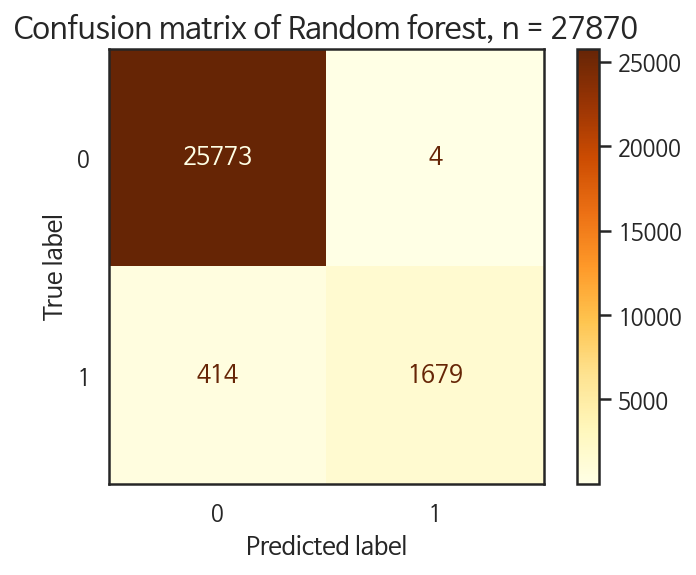

In [246]:
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(best_rf, X_test, y_test,
                            cmap=plt.cm.YlOrBr,
                            ax=ax)
plt.title(f'Confusion matrix of Random forest, n = {len(y_test)}', fontsize=15)
plt.show()

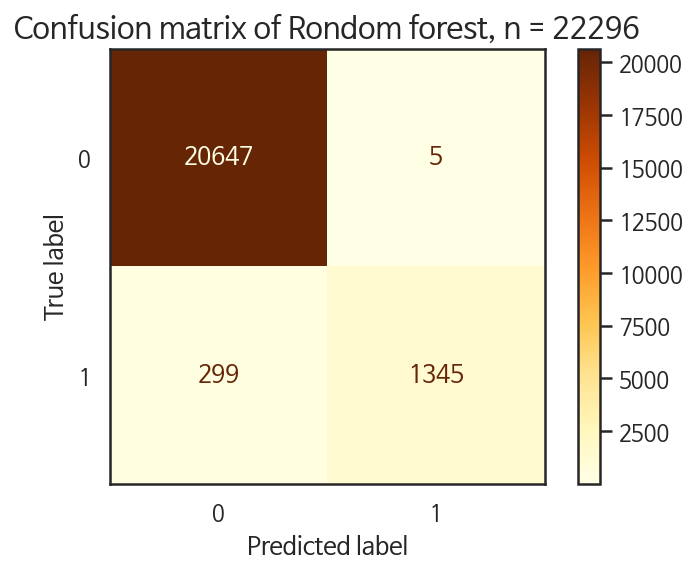

In [245]:
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(best_rf, X_val, y_val,
                            cmap=plt.cm.YlOrBr,
                            ax=ax)
plt.title(f'Confusion matrix of Rondom forest, n = {len(y_val)}', fontsize=15)
plt.show()

모델 해석 - 순열중요도

Text(0.5, 1.0, 'Permution Importance')

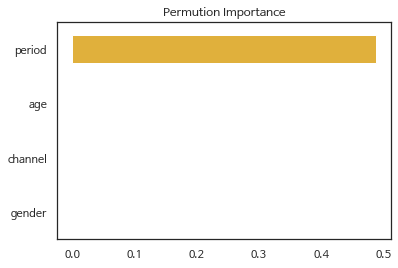

In [229]:
from eli5.sklearn import PermutationImportance
permuter = PermutationImportance(
    best_rf.named_steps['randomforestclassifier'],
    scoring='roc_auc',
    n_iter=5,
    random_state=42,
)

X_val_preprocessed = best_rf[0].transform(X_val) # rf[0] : OrdinalEncoder
permuter.fit(X_val_preprocessed, y_val) # score 재계산

feature_names = X_test.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=True)
pi.tail(10).plot.barh() # 상위 10개
plt.title('Permution Importance')

In [231]:
# 특서별 score 확인
import eli5
eli5.show_weights(
    permuter,
    top=None, # top n 지정 가능, None일 경우 모든 특성
    feature_names=feature_names # list 형식으로 넣어야 함
)

Weight,Feature
0.4882 ± 0.0097,period
0.0002 ± 0.0014,age
-0.0002 ± 0.0003,channel
-0.0004 ± 0.0006,gender


pdp plot

(<Figure size 2160x1368 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='period'>})

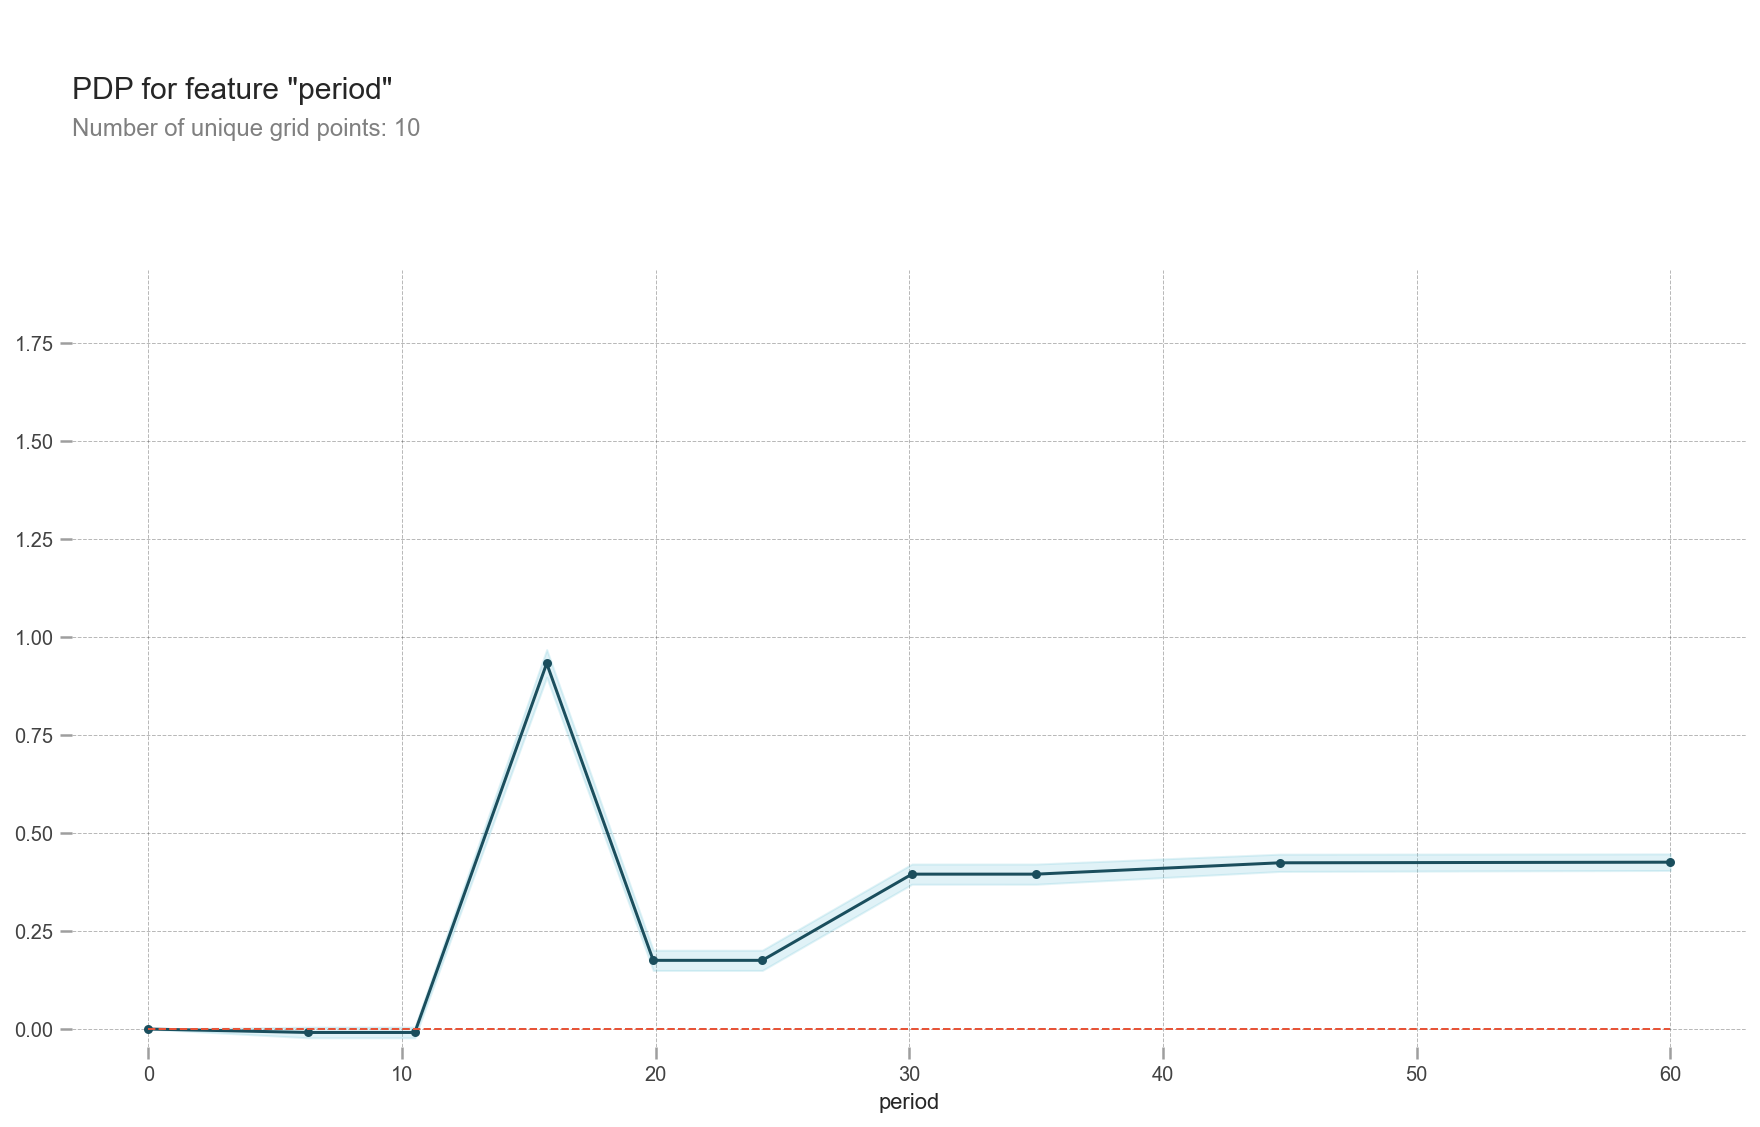

In [233]:
from pdpbox.pdp import pdp_isolate, pdp_plot
plt.rcParams['figure.dpi'] = 144 # 이미지 화질 조정

target_feature = 'period'

isolated = pdp_isolate(
    model=best_rf,
    dataset=X_test,
    model_features=X_test.columns,
    feature=target_feature,
    grid_type='percentile', # default = 'percentile', or 'equal'
    num_grid_points=10 # default = 10
)
pdp_plot(isolated, feature_name=target_feature)

In [248]:
dfm.head()

,age,gender,channel,period,churn
0,70,female,phone,60.0,0
1,60,male,phone,56.2,0
2,50,female,phone,24.4,0
4,70,male,phone,53.9,0
5,50,male,phone,60.0,0


In [250]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['period']

interaction = pdp_interact(
    model=best_rf, 
    dataset=X_test,
    model_features=X_test.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

IndexError: list index out of range